<a href="https://colab.research.google.com/github/Sardorbek-HUB/AI_Application/blob/main/AI_Application_Week11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import requests
url = 'https://raw.githubusercontent.com/NVDLI/LDL/main/pt_framework/utilities.py'
r = requests.get(url)
with open('utilities.py', 'w') as f:
  f.write(r.text)

In [33]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from utilities import train_model

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
EPOCHS = 100
BATCH_SIZE = 16

TRAIN_TEST_SPLIT = 0.8
MIN = 12
FILE_NAME = '/content/book_store_sales.csv'

def readfile(file_name):
  file = open(file_name, 'r', encoding='utf-8')
  next(file)
  data = []
  for line in (file):
    values = line.split(',')
    #print(values)
    data.append(float(values[1]))
  file.close()
  return np.array(data, dtype=np.float32)

sales = readfile(FILE_NAME)
months = len(sales)
split = int(months * TRAIN_TEST_SPLIT)
train_sales = sales[0:split]
test_sales = sales[split:]

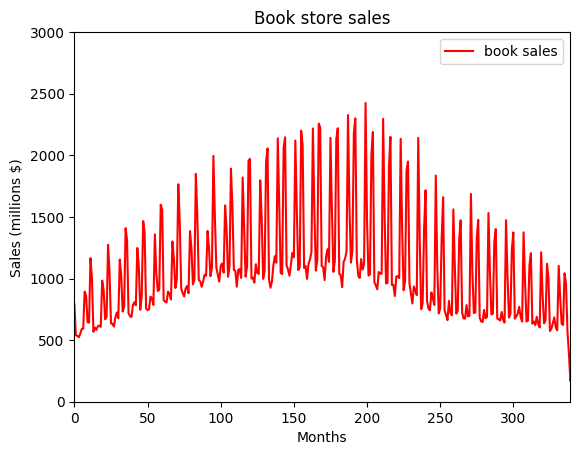

In [34]:
x = range(len(sales))
plt.plot(x, sales, 'r-', label='book sales')
plt.title('Book store sales')
plt.axis([0, 339, 0.0, 3000.0])
plt.xlabel('Months')
plt.ylabel('Sales (millions $)')
plt.legend()
plt.show()

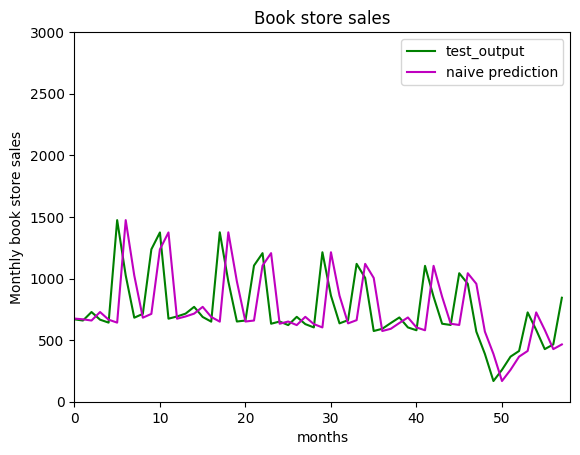

In [35]:
test_output = test_sales[MIN:]
naive_prediction = test_sales[MIN-1:-1]
x = range(len(test_output))
plt.plot(x, test_output, 'g-', label = 'test_output')
plt.plot(x, naive_prediction, 'm-', label = 'naive prediction')
plt.title('Book store sales')
plt.axis([0, len(test_output), 0.0, 3000.0])
plt.xlabel('months')
plt.ylabel('Monthly book store sales')
plt.legend()
plt.show()

In [36]:
mean = np.mean(train_sales)
stddev = np.std(train_sales)
train_sales_std = (train_sales - mean)/stddev
test_sales_std = (test_sales - mean)/stddev

In [46]:
train_months = len(train_sales)
train_X = np.zeros((train_months-MIN, train_months-1, 1), dtype=np.float32)
train_y = np.zeros((train_months-MIN, 1), dtype=np.float32)
for i in range(0, train_months-MIN):
  train_X[i, -(i+MIN):, 0] = train_sales_std[0:i+MIN]
  train_y[i, 0] = train_sales_std[i+MIN]

test_months = len(test_sales)
test_X = np.zeros((test_months-MIN, test_months-1, 1), dtype=np.float32)
test_y = np.zeros((test_months-MIN, 1), dtype=np.float32)
for i in range(0, test_months-MIN):
  test_X[i, -(i+MIN):, 0] = test_sales_std[0:i+MIN]
  test_y[i, 0] = test_sales_std[i+MIN]

trainset = TensorDataset(torch.from_numpy(train_X).clone(), torch.from_numpy(train_y))
testset = TensorDataset(torch.from_numpy(test_X).clone(), torch.from_numpy(test_y))

In [47]:
class LastTimestep(nn.Module):
  def forward(self, inputs):
    return inputs[1][0]

model = nn.Sequential(
    nn.RNN(1, 128, nonlinearity='relu', batch_first=True),
    LastTimestep(),
    nn.Linear(128, 1)
)

optimizer = torch.optim.Adam(model.parameters())
loss_function = nn.MSELoss()

train_model(model, device, EPOCHS, BATCH_SIZE, trainset, testset, optimizer, loss_function, 'mae')

Epoch 1/100 loss: 0.9410 - mae: 0.6974 - val_loss: 1.0553 - val_mae: 0.8056
Epoch 2/100 loss: 0.8434 - mae: 0.6717 - val_loss: 0.8085 - val_mae: 0.6999
Epoch 3/100 loss: 0.6009 - mae: 0.5803 - val_loss: 0.6575 - val_mae: 0.6212
Epoch 4/100 loss: 0.6143 - mae: 0.5684 - val_loss: 0.5696 - val_mae: 0.5911
Epoch 5/100 loss: 0.5088 - mae: 0.5369 - val_loss: 0.2632 - val_mae: 0.3680
Epoch 6/100 loss: 0.4411 - mae: 0.5048 - val_loss: 0.2394 - val_mae: 0.3272
Epoch 7/100 loss: 0.4157 - mae: 0.4931 - val_loss: 0.2821 - val_mae: 0.3913
Epoch 8/100 loss: 0.4089 - mae: 0.4946 - val_loss: 0.2971 - val_mae: 0.4114
Epoch 9/100 loss: 0.4063 - mae: 0.4811 - val_loss: 0.2597 - val_mae: 0.3487
Epoch 10/100 loss: 0.5012 - mae: 0.5361 - val_loss: 0.2939 - val_mae: 0.3994
Epoch 11/100 loss: 0.4496 - mae: 0.5106 - val_loss: 0.3332 - val_mae: 0.4454
Epoch 12/100 loss: 0.3868 - mae: 0.4662 - val_loss: 0.2482 - val_mae: 0.3540
Epoch 13/100 loss: 0.3432 - mae: 0.4416 - val_loss: 0.1915 - val_mae: 0.2793
Epoch 14

[0.10400531923069674, 0.11953860893845558]

In [48]:
test_output = test_sales_std[MIN:]
naive_prediction = test_sales_std[MIN-1:-1]
mean_squared_error = np.mean(np.square(naive_prediction
- test_output))
mean_abs_error = np.mean(np.abs(naive_prediction
- test_output))
print('naive test mse: ', mean_squared_error)
print('naive test mean abs: ', mean_abs_error)

naive test mse:  0.4723033
naive test mean abs:  0.48052385


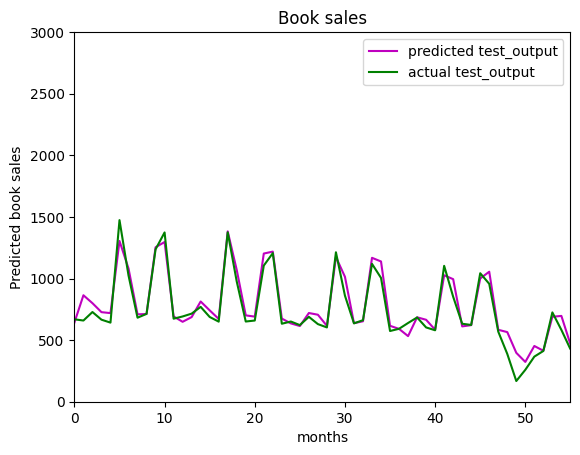

In [49]:
inputs = torch.from_numpy(test_X)
inputs = inputs.to(device)
outputs = model(inputs)
predicted_test = outputs.cpu().detach().numpy()
predicted_test = np.reshape(predicted_test,
(len(predicted_test)))
predicted_test = predicted_test * stddev + mean
# Plot test prediction.
x = range(len(test_sales)-MIN)
plt.plot(x, predicted_test, 'm-',
label='predicted test_output')
plt.plot(x, test_sales[-(len(test_sales)-MIN):],
'g-', label='actual test_output')
plt.title('Book sales')
plt.axis([0, 55, 0.0, 3000.0])
plt.xlabel('months')
plt.ylabel('Predicted book sales')
plt.legend()
plt.show()